# MERFISH Data Prep

Minimal setup for inspecting raw MERFISH files and loading parcellation/metadata tables.

In [24]:
from pathlib import Path

import pandas as pd
import scanpy as sc

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 200)

In [25]:
BASE_DIR = Path("/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish")
PARCELLATION_CSV = Path("/Users/christoffer/Downloads/parcellation.csv")
METADATA_CSV = Path("/Users/christoffer/Downloads/metadata.csv")

In [26]:
required_paths = {
    "base_dir": BASE_DIR,
    "parcellation_csv": PARCELLATION_CSV,
    "metadata_csv": METADATA_CSV,
}

for name, p in required_paths.items():
    print(f"{name:16} exists={p.exists()} path={p}")

base_dir         exists=True path=/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish
parcellation_csv exists=True path=/Users/christoffer/Downloads/parcellation.csv
metadata_csv     exists=True path=/Users/christoffer/Downloads/metadata.csv


In [27]:
raw_files = sorted(
    p.name
    for p in BASE_DIR.iterdir()
    if p.is_file() and p.suffix == ".h5ad" and not p.name.startswith("._")
)
print(f"Found {len(raw_files)} .h5ad files in {BASE_DIR}")
raw_files


Found 4 .h5ad files in /Volumes/processing2/KaroSpaceDataWrangle/raw/merfish


['raw_counts_mouse1_coronal.h5ad',
 'raw_counts_mouse2_coronal.h5ad',
 'raw_counts_mouse3_sagittal.h5ad',
 'raw_counts_mouse4_sagittal.h5ad']

In [28]:
parcellation = pd.read_csv(PARCELLATION_CSV)
metadata = pd.read_csv(METADATA_CSV)

print(f"parcellation shape: {parcellation.shape}")
print(f"metadata shape:     {metadata.shape}")

parcellation.head(), metadata.head()

parcellation shape: (5402051, 8)
metadata shape:     (5822737, 17)


(   Unnamed: 0                               cell_label          x         y         z  parcellation_index            dataset      date
 0           0  177536119734259275144748435471942472531  12.392545  3.367893  1.954545                   0  Zhuang-ABCA-4-CCF  20230830
 1           1  256532006537596385088807329967308781746  12.385892  3.406324  1.954782                   0  Zhuang-ABCA-4-CCF  20230830
 2           2   28801318882950773770397006451868070066  12.378531  3.350464  1.956634                   0  Zhuang-ABCA-4-CCF  20230830
 3           3  301971869963235435117242882149875853185  12.380202  3.343970  1.956501                   0  Zhuang-ABCA-4-CCF  20230830
 4           4   81203938259029510162263594992098070595  12.378271  3.351650  1.956652                   0  Zhuang-ABCA-4-CCF  20230830,
    Unnamed: 0                               cell_label brain_section_label feature_matrix_label    donor_label donor_genotype donor_sex  cluster_alias         x         y        z  \

## Build `cell_label` Lookup Tables

Normalize both CSVs to `cell_label` index, remove duplicates, and prefix columns to avoid name collisions.

In [29]:
def build_cell_label_lookup(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    if "cell_label" not in df.columns:
        raise KeyError(f"Missing required column: cell_label in {prefix}")

    out = df.copy()
    unnamed = [c for c in out.columns if str(c).startswith("Unnamed:")]
    if unnamed:
        out = out.drop(columns=unnamed)

    out["cell_label"] = out["cell_label"].astype(str)
    n_dupes = int(out["cell_label"].duplicated().sum())
    if n_dupes:
        print(f"[{prefix}] dropping {n_dupes} duplicate cell_label rows (keeping first)")
    out = out.drop_duplicates(subset="cell_label", keep="first").set_index("cell_label")
    out.index = out.index.astype(str)
    out = out.add_prefix(f"{prefix}__")
    return out

metadata_lookup = build_cell_label_lookup(metadata, prefix="meta")
parcellation_lookup = build_cell_label_lookup(parcellation, prefix="parc")

print("metadata_lookup:", metadata_lookup.shape)
print("parcellation_lookup:", parcellation_lookup.shape)
metadata_lookup.head(2), parcellation_lookup.head(2)


metadata_lookup: (5822737, 15)
parcellation_lookup: (5402051, 6)


(                                        meta__brain_section_label meta__feature_matrix_label meta__donor_label meta__donor_genotype meta__donor_sex  meta__cluster_alias   meta__x   meta__y  meta__z  \
 cell_label                                                                                                                                                                                              
 182941331246012878296807398333956011710         Zhuang-ABCA-1.089              Zhuang-ABCA-1     Zhuang-ABCA-1                wt/wt               F                  704  0.682522  3.366483  7.82953   
 221260934538535633595532020856387724686         Zhuang-ABCA-1.089              Zhuang-ABCA-1     Zhuang-ABCA-1                wt/wt               F                 5243  0.667690  3.442241  7.82953   
 
                                          meta__subclass_confidence_score  meta__cluster_confidence_score  meta__high_quality_transfer                   meta__abc_sample_id  meta__dataset  m

In [30]:
from pathlib import Path

CLUSTER_ANNOTATION_CSV = Path(
    "/Users/christoffer/work/karolinska/development/Allen_ABC/data/abc_atlas/metadata/WMB-taxonomy/20231215/views/cluster_to_cluster_annotation_membership_pivoted.csv"
)

cluster_annotation = pd.read_csv(CLUSTER_ANNOTATION_CSV)
if "cluster_alias" not in cluster_annotation.columns:
    raise KeyError("Missing required column: cluster_alias in cluster_annotation")

cluster_annotation["cluster_alias"] = cluster_annotation["cluster_alias"].astype(str)
cluster_dupes = int(cluster_annotation["cluster_alias"].duplicated().sum())
if cluster_dupes:
    print(f"[cluster_annotation] dropping {cluster_dupes} duplicate cluster_alias rows (keeping first)")

cluster_annotation_lookup = (
    cluster_annotation.drop_duplicates(subset="cluster_alias", keep="first")
    .set_index("cluster_alias")
    .add_prefix("clu__")
)
cluster_annotation_lookup.index = cluster_annotation_lookup.index.astype(str)

print("cluster_annotation_lookup:", cluster_annotation_lookup.shape)
cluster_annotation_lookup.head(2)



In [31]:
cluster_annotation

,neurotransmitter,class,subclass,supertype,cluster
cluster_alias,,,,,
1,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0326 L2 IT PPP-APr Glut_3
2,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0082 L2 IT PPP-APr Glut_3,0327 L2 IT PPP-APr Glut_3
3,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0322 L2 IT PPP-APr Glut_2
4,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0323 L2 IT PPP-APr Glut_2
5,Glut,01 IT-ET Glut,018 L2 IT PPP-APr Glut,0081 L2 IT PPP-APr Glut_2,0325 L2 IT PPP-APr Glut_2
...,...,...,...,...,...
34368,GABA-Glyc,27 MY GABA,288 MDRN Hoxb5 Ebf2 Gly-Gaba,1102 MDRN Hoxb5 Ebf2 Gly-Gaba_1,4955 MDRN Hoxb5 Ebf2 Gly-Gaba_1
34372,GABA-Glyc,27 MY GABA,285 MY Lhx1 Gly-Gaba,1091 MY Lhx1 Gly-Gaba_3,4901 MY Lhx1 Gly-Gaba_3
34374,GABA-Glyc,27 MY GABA,285 MY Lhx1 Gly-Gaba,1091 MY Lhx1 Gly-Gaba_3,4902 MY Lhx1 Gly-Gaba_3


## Assemble AnnData By `cell_label`

Join `metadata` and `parcellation` onto `adata.obs` where `adata.obs.index == cell_label`.

In [43]:
import anndata as ad
import numpy as np

TARGET_H5AD = BASE_DIR / "raw_counts_mouse4_sagittal.h5ad"  # change as needed
adata = ad.read_h5ad(TARGET_H5AD)
adata.obs_names = adata.obs_names.astype(str)

adata.obs = adata.obs.join(metadata_lookup, how="left")
adata.obs = adata.obs.join(parcellation_lookup, how="left")
adata.obs["sample_id"] = TARGET_H5AD.stem.replace("raw_counts_", "")

# If spatial coordinates are missing, derive from parcellation x/y
if "spatial" not in adata.obsm and {"parc__x", "parc__y"}.issubset(adata.obs.columns):
    xy = adata.obs[["parc__x", "parc__y"]].to_numpy(dtype=np.float32)
    adata.obsm["spatial"] = xy

n = adata.n_obs
meta_match = int(adata.obs["meta__dataset"].notna().sum()) if "meta__dataset" in adata.obs else 0
parc_match = int(adata.obs["parc__parcellation_index"].notna().sum()) if "parc__parcellation_index" in adata.obs else 0
print(f"adata: {adata.n_obs:,} cells x {adata.n_vars:,} features")
print(f"metadata matches:     {meta_match:,} ({meta_match / n:.2%})")
print(f"parcellation matches: {parc_match:,} ({parc_match / n:.2%})")

adata


adata: 215,300 cells x 1,147 features
metadata matches:     162,578 (75.51%)
parcellation matches: 162,361 (75.41%)


AnnData object with n_obs × n_vars = 215300 × 1147
    obs: 'fov', 'volume', 'center_x', 'center_y', 'sample_id', 'slice_id', 'fov_x', 'fov_y', 'meta__brain_section_label', 'meta__feature_matrix_label', 'meta__donor_label', 'meta__donor_genotype', 'meta__donor_sex', 'meta__cluster_alias', 'meta__x', 'meta__y', 'meta__z', 'meta__subclass_confidence_score', 'meta__cluster_confidence_score', 'meta__high_quality_transfer', 'meta__abc_sample_id', 'meta__dataset', 'meta__date', 'parc__x', 'parc__y', 'parc__z', 'parc__parcellation_index', 'parc__dataset', 'parc__date'
    obsm: 'spatial'

In [47]:
adata.obs

,fov,volume,center_x,center_y,sample_id,slice_id,fov_x,fov_y,meta__brain_section_label,meta__feature_matrix_label,meta__donor_label,meta__donor_genotype,meta__donor_sex,meta__cluster_alias,meta__x,meta__y,meta__z,meta__subclass_confidence_score,meta__cluster_confidence_score,meta__high_quality_transfer,meta__abc_sample_id,meta__dataset,meta__date,parc__x,parc__y,parc__z,parc__parcellation_index,parc__dataset,parc__date
104367712102725177087239619995470724493,2,600.952956,4683.353749,304.608241,mouse4_sagittal,sa2_slice2,4656.50,139.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
177536119734259275144748435471942472531,2,265.751109,4688.832999,310.358741,mouse4_sagittal,sa2_slice2,4656.50,139.20,Zhuang-ABCA-4.002,Zhuang-ABCA-4,Zhuang-ABCA-4,wt/wt,M,5249.0,12.845605,3.428535,1.958952,0.998365,0.806205,True,5d53075c-ca36-40d5-a718-31e519b2abfb,Zhuang-ABCA-4,20241115.0,12.392545,3.367893,1.954545,0.0,Zhuang-ABCA-4-CCF,20230830.0
256532006537596385088807329967308781746,2,510.273675,4697.295999,348.008240,mouse4_sagittal,sa2_slice2,4656.50,139.20,Zhuang-ABCA-4.002,Zhuang-ABCA-4,Zhuang-ABCA-4,wt/wt,M,4167.0,12.854068,3.466185,1.958952,0.928926,0.928926,True,88ba4908-07d8-48a2-a85e-d0c10392c2ec,Zhuang-ABCA-4,20241115.0,12.385892,3.406324,1.954782,0.0,Zhuang-ABCA-4-CCF,20230830.0
28801318882950773770397006451868070066,2,452.607960,4671.472999,291.099992,mouse4_sagittal,sa2_slice2,4656.50,139.20,Zhuang-ABCA-4.002,Zhuang-ABCA-4,Zhuang-ABCA-4,wt/wt,M,5252.0,12.828245,3.409277,1.958952,0.963517,0.948538,True,4d018b6c-0b56-4c2c-b8fe-b591ac155118,Zhuang-ABCA-4,20241115.0,12.378531,3.350464,1.956634,0.0,Zhuang-ABCA-4-CCF,20230830.0
301971869963235435117242882149875853185,2,110.665735,4670.496500,284.915492,mouse4_sagittal,sa2_slice2,4656.50,139.20,Zhuang-ABCA-4.002,Zhuang-ABCA-4,Zhuang-ABCA-4,wt/wt,M,5252.0,12.827268,3.403092,1.958952,0.999984,0.853408,True,ac646972-132e-4773-9d14-42b426481b8a,Zhuang-ABCA-4,20241115.0,12.380202,3.343970,1.956501,0.0,Zhuang-ABCA-4-CCF,20230830.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165336829713404196890968979758300983951,782,267.047858,-2818.452034,454.928547,mouse4_sagittal,sa2_slice1,-3013.78,235.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
208310273664740998320466646194827109394,782,697.705810,-2817.798034,440.763997,mouse4_sagittal,sa2_slice1,-3013.78,235.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22952685842782775539589495413976810844,782,697.839650,-2814.528034,419.399998,mouse4_sagittal,sa2_slice1,-3013.78,235.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
266226389764367102976499556952863936382,782,393.943347,-2801.884034,392.803999,mouse4_sagittal,sa2_slice1,-3013.78,235.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Optional: write enriched file
OUT_H5AD = BASE_DIR / f"{TARGET_H5AD.stem}_annotated.h5ad"
print("Will write:", OUT_H5AD)
# adata.write_h5ad(OUT_H5AD)



Will write: /Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/raw_counts_mouse4_sagittal_annotated.h5ad


In [50]:
# Process files one-by-one, then build sagittal/coronal outputs on disk
import gc
import anndata as ad
import pandas as pd

# Required for writing pandas nullable string columns with anndata>=0.11
ad.settings.allow_write_nullable_strings = True
import numpy as np
from pathlib import Path

PROCESSED_DIR = BASE_DIR / "processed_mapped"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Set to None for auto-detect among common candidates.
CLUSTER_ALIAS_OBS_COL = "meta__cluster_alias"

h5ad_paths = sorted(p for p in BASE_DIR.glob("raw_counts_*.h5ad") if not p.name.startswith("._"))


def _orientation_from_name(path: Path) -> str:
    s = path.stem.lower()
    if "coronal" in s:
        return "coronal"
    if "sagittal" in s or "sagital" in s:
        return "sagittal"
    return "unknown"




def _sanitize_obs_for_h5ad(obs_df):
    """Make obs columns serializable by anndata/h5py."""
    out = obs_df.copy()
    for col in out.columns:
        ser = out[col]

        # Categorical columns with non-string categories can also trip h5 writing.
        if pd.api.types.is_categorical_dtype(ser):
            if ser.cat.categories.dtype == object:
                out[col] = ser.astype("string")
            continue

        if pd.api.types.is_object_dtype(ser) or pd.api.types.is_string_dtype(ser):
            non_na = ser.dropna()
            if non_na.empty:
                out[col] = ser.astype("string")
                continue

            # Pure booleans -> nullable boolean.
            bool_like = non_na.map(lambda x: isinstance(x, (bool, np.bool_))).all()
            if bool_like:
                out[col] = ser.astype("boolean")
                continue

            # Pure numbers -> numeric dtype.
            num = pd.to_numeric(ser, errors="coerce")
            if int(num.notna().sum()) == int(ser.notna().sum()):
                out[col] = num
                continue

            # Fallback: force text representation in a nullable string dtype.
            out[col] = ser.astype("string")

    return out

def _map_cluster_annotations(obs_df, cluster_lookup, cluster_alias_col=None):
    candidates = [
        cluster_alias_col,
        "meta__cluster_alias",
        "cluster_alias",
        "meta__cluster",
        "cluster",
    ]
    alias_col = next((c for c in candidates if c and c in obs_df.columns), None)
    if alias_col is None:
        print("  [warn] no cluster alias column found in obs; skipping cluster annotation mapping")
        return obs_df, None

    out = obs_df.copy()
    out[alias_col] = out[alias_col].astype("string")
    out = out.join(cluster_lookup, on=alias_col, how="left")
    return out, alias_col


orientation_paths = {
    "sagittal": [p for p in h5ad_paths if _orientation_from_name(p) == "sagittal"],
    "coronal": [p for p in h5ad_paths if _orientation_from_name(p) == "coronal"],
}

for orientation in ("sagittal", "coronal"):
    print(f"{orientation.title()} files:", [p.name for p in orientation_paths[orientation]])

processed_by_orientation = {"sagittal": [], "coronal": []}
cluster_cols = list(cluster_annotation_lookup.columns)
cluster_metric_col = cluster_cols[0] if cluster_cols else None

for orientation in ("sagittal", "coronal"):
    for path in orientation_paths[orientation]:
        print(f"\nProcessing {path.name} ({orientation})")
        adata_one = ad.read_h5ad(path)
        adata_one.obs_names = adata_one.obs_names.astype(str)

        obs = adata_one.obs.copy()
        obs["sample_id"] = path.stem.replace("raw_counts_", "")
        obs["orientation"] = orientation

        obs = obs.join(metadata_lookup, how="left")
        obs = obs.join(parcellation_lookup, how="left")
        obs, alias_col_used = _map_cluster_annotations(
            obs,
            cluster_annotation_lookup,
            cluster_alias_col=CLUSTER_ALIAS_OBS_COL,
        )

        # Ensure obs columns are H5AD-serializable (avoids mixed object dtype write failures)
        obs = _sanitize_obs_for_h5ad(obs)
        adata_one.obs = obs

        if "spatial" not in adata_one.obsm and {"parc__x", "parc__y"}.issubset(adata_one.obs.columns):
            adata_one.obsm["spatial"] = adata_one.obs[["parc__x", "parc__y"]].to_numpy(dtype=np.float32)

        meta_match = int(adata_one.obs["meta__dataset"].notna().sum()) if "meta__dataset" in adata_one.obs else 0
        parc_match = int(adata_one.obs["parc__parcellation_index"].notna().sum()) if "parc__parcellation_index" in adata_one.obs else 0
        cluster_match = (
            int(adata_one.obs[cluster_metric_col].notna().sum()) if cluster_metric_col in adata_one.obs else 0
        )

        out_path = PROCESSED_DIR / f"{path.stem}__mapped.h5ad"
        adata_one.write_h5ad(out_path, convert_strings_to_categoricals=False)
        processed_by_orientation[orientation].append(out_path)

        print(f"  wrote: {out_path.name}")
        print(f"  cells: {adata_one.n_obs:,}")
        print(f"  metadata matches: {meta_match:,} ({meta_match / adata_one.n_obs:.2%})")
        print(f"  parcellation matches: {parc_match:,} ({parc_match / adata_one.n_obs:.2%})")
        if cluster_metric_col:
            label = alias_col_used if alias_col_used else "cluster_alias"
            print(f"  cluster matches ({label}): {cluster_match:,} ({cluster_match / adata_one.n_obs:.2%})")

        del adata_one
        gc.collect()


def _concat_on_disk_or_fallback(input_paths, output_path, orientation_name):
    if not input_paths:
        print(f"No {orientation_name} mapped files to concatenate")
        return None

    keys = [p.stem.replace("__mapped", "") for p in input_paths]
    try:
        from anndata.experimental import concat_on_disk

        concat_on_disk(
            [str(p) for p in input_paths],
            out_file=str(output_path),
            axis=0,
            join="outer",
            merge="same",
            label="source_file",
            keys=keys,
            index_unique=None,
        )
        print(f"Built on disk with concat_on_disk: {output_path.name}")
    except Exception as e:
        print(f"concat_on_disk unavailable ({type(e).__name__}: {e}); using in-memory fallback for {orientation_name}")
        parts = [ad.read_h5ad(p) for p in input_paths]
        out = ad.concat(
            parts,
            join="outer",
            merge="same",
            label="source_file",
            keys=keys,
            index_unique=None,
        )
        out.write_h5ad(output_path, convert_strings_to_categoricals=False)
        del out, parts
        gc.collect()
        print(f"Built with fallback concat: {output_path.name}")

    return output_path


adata_sagittal_path = _concat_on_disk_or_fallback(
    processed_by_orientation["sagittal"],
    PROCESSED_DIR / "adata_sagittal_mapped.h5ad",
    "sagittal",
)
adata_coronal_path = _concat_on_disk_or_fallback(
    processed_by_orientation["coronal"],
    PROCESSED_DIR / "adata_coronal_mapped.h5ad",
    "coronal",
)

for name, out_path in [("adata_sagittal", adata_sagittal_path), ("adata_coronal", adata_coronal_path)]:
    if out_path is None or not Path(out_path).exists():
        continue
    b = ad.read_h5ad(out_path, backed="r")
    print(f"{name}: {b.n_obs:,} cells x {b.n_vars:,} genes -> {out_path}")
    if hasattr(b, "file") and b.file is not None:
        b.file.close()







Sagittal files: ['raw_counts_mouse3_sagittal.h5ad', 'raw_counts_mouse4_sagittal.h5ad']
Coronal files: ['raw_counts_mouse1_coronal.h5ad', 'raw_counts_mouse2_coronal.h5ad']

Processing raw_counts_mouse3_sagittal.h5ad (sagittal)


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

  wrote: raw_counts_mouse3_sagittal__mapped.h5ad
  cells: 2,234,445
  metadata matches: 1,585,843 (70.97%)
  parcellation matches: 1,566,842 (70.12%)
  cluster matches (meta__cluster_alias): 0 (0.00%)

Processing raw_counts_mouse4_sagittal.h5ad (sagittal)


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

  wrote: raw_counts_mouse4_sagittal__mapped.h5ad
  cells: 215,300
  metadata matches: 162,578 (75.51%)
  parcellation matches: 162,361 (75.41%)
  cluster matches (meta__cluster_alias): 0 (0.00%)

Processing raw_counts_mouse1_coronal.h5ad (coronal)


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

  wrote: raw_counts_mouse1_coronal__mapped.h5ad
  cells: 2,091,291
  metadata matches: 1,227,408 (58.69%)
  parcellation matches: 1,056,520 (50.52%)
  cluster matches (meta__cluster_alias): 0 (0.00%)

Processing raw_counts_mouse2_coronal.h5ad (coronal)


/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(ser):
/var/folders/pm/2253tbm54v36j0l7lhshq73r0000gn/T/ipykernel_83007/872513898.py:38: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

  wrote: raw_counts_mouse2_coronal__mapped.h5ad
  cells: 4,802,421
  metadata matches: 2,846,908 (59.28%)
  parcellation matches: 2,616,328 (54.48%)
  cluster matches (meta__cluster_alias): 0 (0.00%)
Built on disk with concat_on_disk: adata_sagittal_mapped.h5ad
Built on disk with concat_on_disk: adata_coronal_mapped.h5ad
adata_sagittal: 2,449,745 cells x 1,147 genes -> /Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_sagittal_mapped.h5ad
adata_coronal: 6,893,712 cells x 1,147 genes -> /Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_coronal_mapped.h5ad


## Notes
- Mapping key is strictly `cell_label` (as string).
- Prefixes are used to prevent column collisions: `meta__*`, `parc__*`.
- Builds separate merged objects: `adata_coronal` and `adata_sagittal`.
- Full-orientation concatenation is still memory heavy; test one sample first if needed.

In [51]:
ad_sag = sc.read_h5ad('/Volumes/processing2/KaroSpaceDataWrangle/raw/merfish/processed_mapped/adata_sagittal_mapped.h5ad')

In [ ]:
ad_sag.X.

array([[0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]],
      shape=(2449745, 1147), dtype=float32)

In [65]:
import numpy as np
import scipy.sparse as sp
import scanpy as sc

# 1) Clean non-finite values first
if sp.issparse(ad_sag.X):
    bad = ~np.isfinite(adata.X.data)
    if bad.any():
        adata.X.data[bad] = 0.0
else:
    ad_sag.X = np.nan_to_num(ad_sag.X, nan=0.0, posinf=0.0, neginf=0.0)

# 2) HVG should be run on log-normalized data for flavor='seurat'
ad_sag.layers["counts"] = ad_sag.X.copy()   # keep raw counts
sc.pp.normalize_total(ad_sag, target_sum=1e4)
sc.pp.log1p(ad_sag)

# 3) Run HVG
sc.pp.highly_variable_genes(ad_sag, flavor="seurat", n_top_genes=100)


In [62]:
import sys
sys.path.append("/Users/christoffer/work/karolinska/development/MANA")
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast

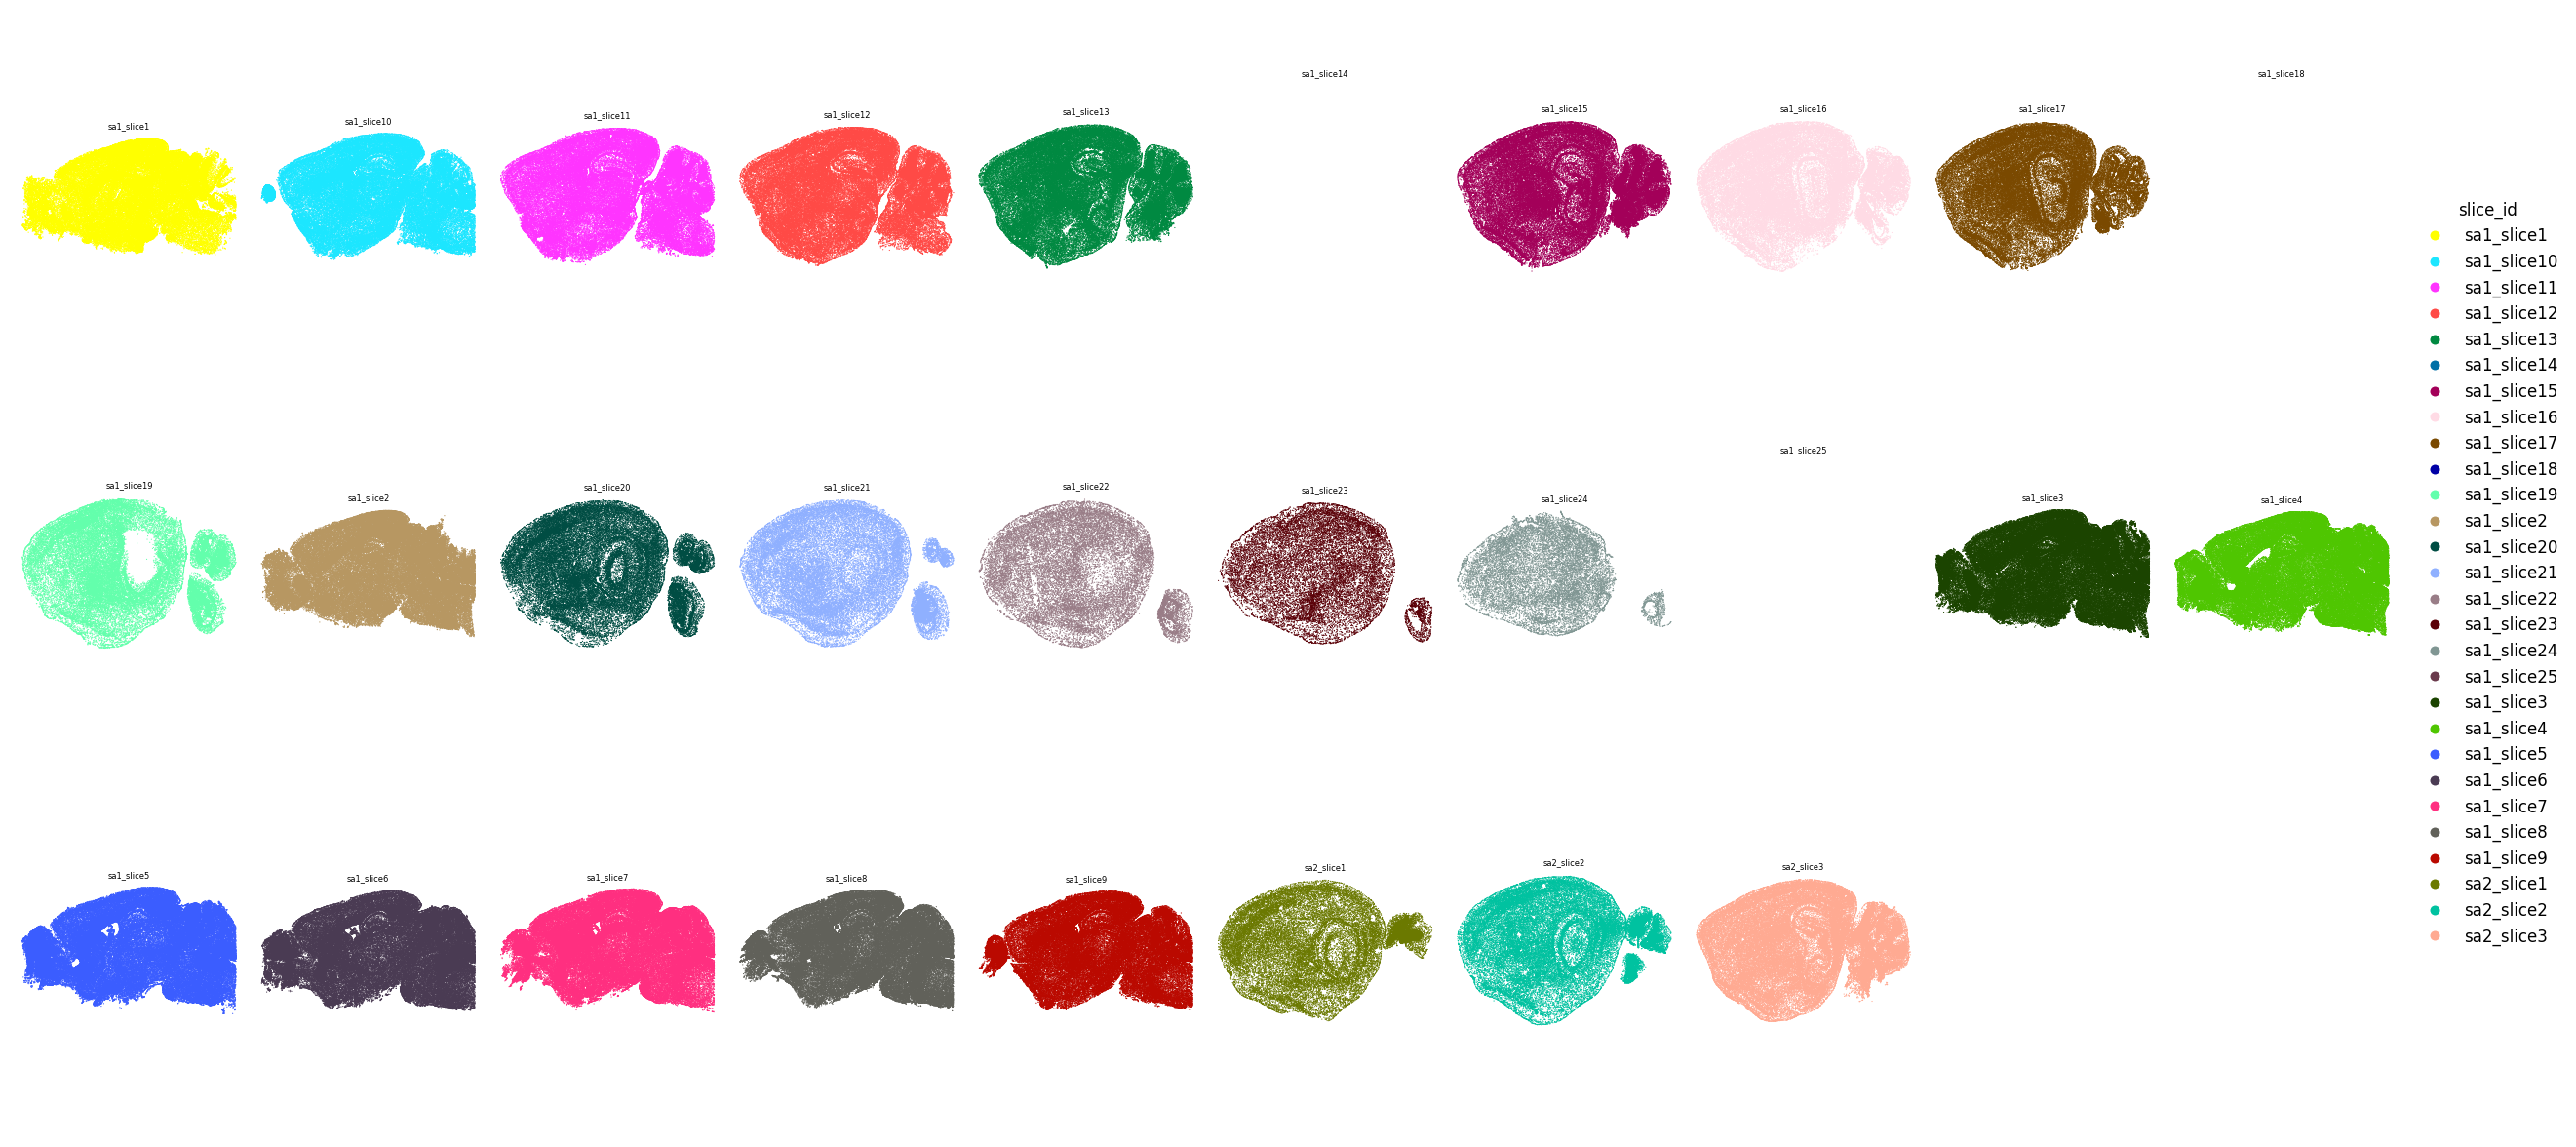

In [66]:
plot_spatial_compact_fast(
    ad_sag,
    color="slice_id",
    groupby="slice_id",
    spot_size=0.5,
    cols=10,
    height=10,
    background="white",
    dpi=120,
)


In [70]:
import squidpy as sq

/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


TypeError: Expected `adata.obs['slice_id']` to be `categorical`, found `string`.

In [76]:
ad_sag.obs['slice_id'] = ad_sag.obs['slice_id'].astype('category')

In [84]:
np.array(ad_sag.obs[['center_x','center_y']])

array([[-5403.40920202,  5618.73444211],
       [-5392.1252024 ,  5564.80994392],
       [-5386.05462761,  5607.61319248],
       ...,
       [-2814.52803409,   419.39999801],
       [-2801.8840344 ,   392.80399865],
       [-2822.10353391,   437.76649757]], shape=(2449745, 2))

In [86]:
ad_sag.obsm['spatial'] = np.array(ad_sag.obs[['center_x','center_y']])

In [87]:
sq.gr.spatial_neighbors(ad_sag, library_key='slice_id', coord_type='generic', delaunay=True)


In [89]:
import cellcharter as cc


/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <0B7EB158-53DC-3403-8A49-22178CAB4612> /Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/torchvision/image.so
  Reason: tried: '/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/christoffer/miniconda3/envs/cellcharter310/lib/python3.10/site-packages/torchvi

In [ ]:
cc.gr.remove_long_links(ad_sag)


: 

In [ ]:
cc.gr.aggregate_neighbors(ad_sag, n_layers=3)


 75%|███████▌  | 3/4 [00:38<00:13, 13.98s/it]